# Operationalizer

**Variables to be operationalized**
- price in USD
- category variable
- ARF (market entry strategy) 
- market exit (deletion of account)
- ARM (time series)
- selling price adjustment (time series)
- proportion of negative feedbacks (time series)


In [23]:
import pandas as pd
import numpy as np

# plotting setup
import matplotlib.pyplot as plt
import matplotlib as mpl; mpl.rcParams['figure.dpi']= 300

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import nbextensions
import datetime
import os
import swifter

## Silkroad2 Item Information

In [2]:
folder = '/Volumes/Extreme SSD/data/final/silkroad2'
file   = 'items.pickle'

df = pd.read_pickle(os.path.join(folder, file))

In [3]:
t_max = df['rtime_dt'].max()
t_min = df['rtime_dt'].min()

df.sample(5)

,vendor,stime,stime_dt,stime_str,rating,feedback,item,price,freshness,rtime,rtime_dt,location,area
1246234,Narcolepsy83,1.414316e+09,2014-10-26 09:32:48,2014-10-27,5,"Recieved on 3rd day of shipping, very fast. AM...","Ethylone Crystals- 500grams (E1, EVE, MDEC, bk...",4.395267,0,1.414316e+09,2014-10-26 09:32:48,Undeclared,Worldwide
518575,remoutlet,1.408831e+09,2014-08-23 21:55:18,2014-07-17,5,zoplis just landed 1 day delivery UK stealth w...,█ LSD Blotter 110ug x1,0.016044,192,1.392242e+09,2014-02-12 21:55:18,United Kingdom,United Kingdom
1301255,online-cannabis-king93,1.414627e+09,2014-10-30 00:00:01,2014-11-01,5,Fast Delivery. Good Vendor :),Power Plant 3gr,0.118713,291,1.389485e+09,2014-01-12 00:00:01,Germany,Worldwide
1114589,UnknownSeller66,1.413054e+09,2014-10-11 18:56:21,2014-10-12,5,I can enlighten you on your poor score. It ref...,Valium 10mg (ROCHE) BULK DEAL USA-USA Domestic...,1.357457,27,1.410721e+09,2014-09-14 18:56:21,United States,United States
18721,gotmilk,1.402430e+09,2014-06-10 19:47:25,2014-02-11,5,Good product and stealth. My favorite on SR,2 boxes of Menabol- Stanozolol Tabs 2mg Cfl 10...,0.292671,2,1.402257e+09,2014-06-08 19:47:25,India,Worldwide


## Bitcoin Conversion information

In [4]:
# scrape Bitcoin data
url = "https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130429&end=20200212"

bitcoin_data = pd.read_html(url)[2]
bitcoin_data.columns =  map(str.lower, bitcoin_data.columns)

In [5]:
bitcoin_data = bitcoin_data[['date', 'open*', 'high', 'low', 'close**']]\
    .assign(date = pd.to_datetime(bitcoin_data['date']),
            mean = bitcoin_data[['high', 'low']].mean(axis=1))\
    .sort_values('date')\
    .reset_index(drop = True)

# define observation period
observation_period = (bitcoin_data['date'] > t_min)\
                      & (bitcoin_data['date'] < t_max)

max_bit = bitcoin_data[observation_period]['mean'].max()
min_bit = bitcoin_data[observation_period]['mean'].min()

In [6]:
bitcoin_data

,date,open*,high,low,close**,mean
0,2013-04-29,134.44,147.49,134.00,144.54,140.745
1,2013-04-30,144.00,146.93,134.05,139.00,140.490
2,2013-05-01,139.00,139.89,107.72,116.99,123.805
3,2013-05-02,116.38,125.60,92.28,105.21,108.940
4,2013-05-03,106.25,108.13,79.10,97.75,93.615
...,...,...,...,...,...,...
2476,2020-02-08,9793.07,9876.75,9678.91,9865.12,9777.830
2477,2020-02-09,9863.89,10129.44,9850.39,10116.67,9989.915
2478,2020-02-10,10115.56,10165.77,9784.56,9856.61,9975.165
2479,2020-02-11,9855.89,10210.05,9729.33,10208.24,9969.690


### Fluctiations in bitcoin price

Bitcoin infamously known for its price flucuations. Although the window of observation of this study is way beyond the "bitcoin bubble" occured, there were considerable changes in bitcoin prices overtime.  {{max_bit}}

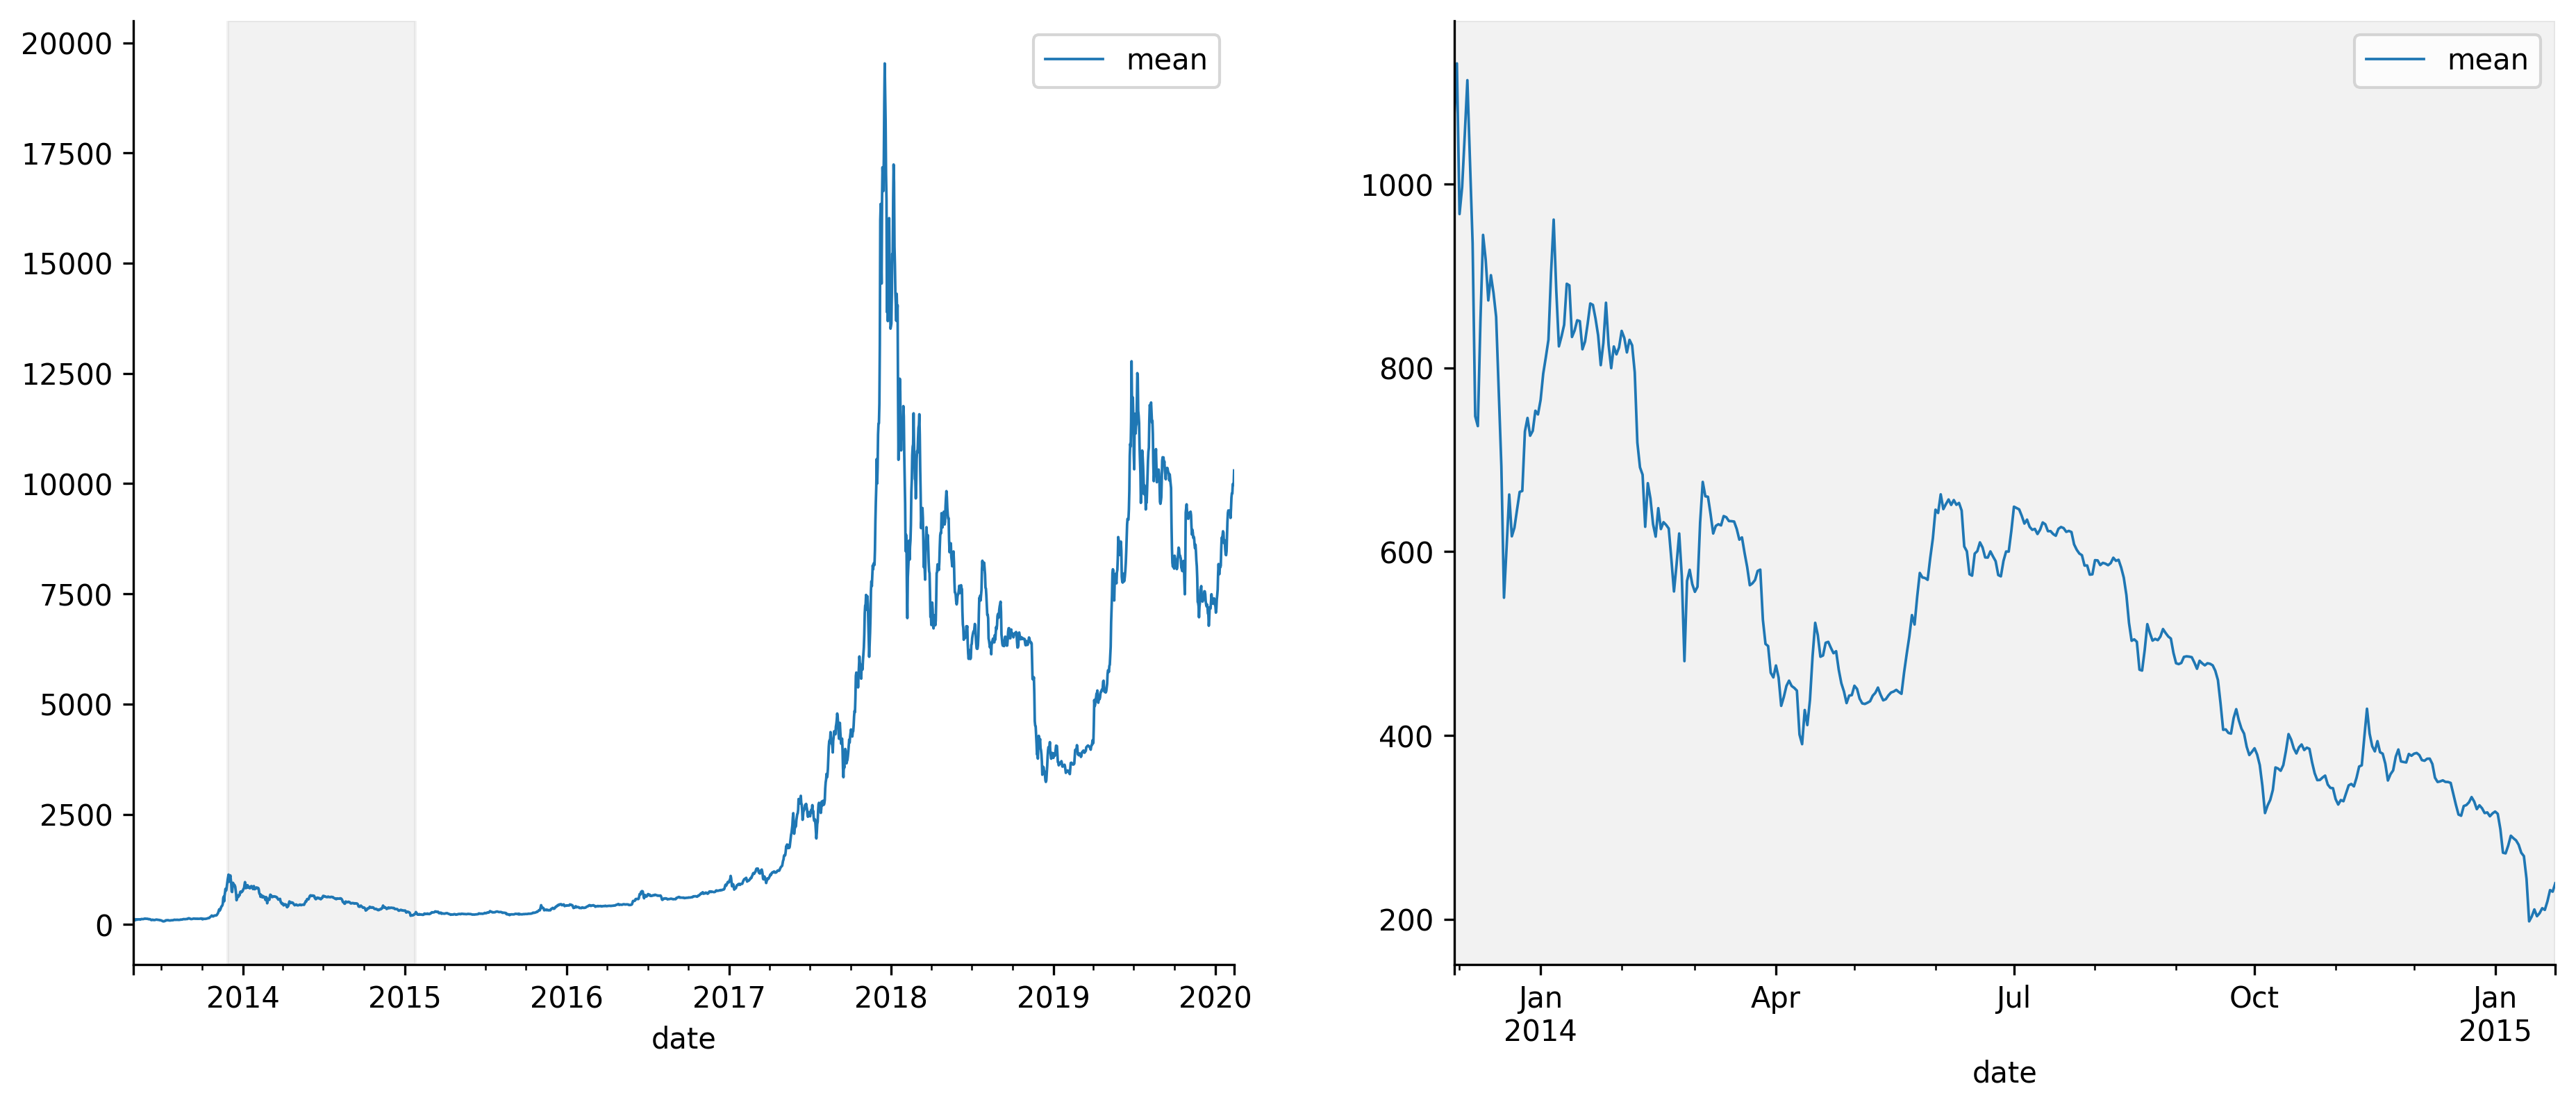

In [28]:
# initiate subplots
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15, 6))

# all time
bitcoin_data.plot(
    linewidth = .9,
    x = 'date',
    y = 'mean',
    ax = ax1
)

ax1.axvspan(t_min, t_max, color='grey', alpha=0.1)

# time window of observations
bitcoin_data.loc[observation_period].plot(
    linewidth = .9,
    x = 'date',
    y = 'mean',
    ax = ax2
)

ax2.axvspan(t_min, t_max, color='grey', alpha=0.1)

plt.show()

## Converting bitcoin to USD

To make the prices comparable over time points we convert te bitcoin prices to USD. 

In [8]:
def get_bitcoin_price(date):
    if not pd.isnull(date):
        date = date.strftime("%Y-%m-%d")
        price = bitcoin_data[bitcoin_data['date'] == date]\
            .loc[:,'mean']\
            .values[0]
    else:
        price = np.nan
    
    return price

# the swifter packages applies mutations more efficiently
df['price_usd'] = df.swifter.apply(lambda row: row['price'] * get_bitcoin_price(row.rtime_dt), axis = 1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tqdm/_tqdm.py:603: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


25063


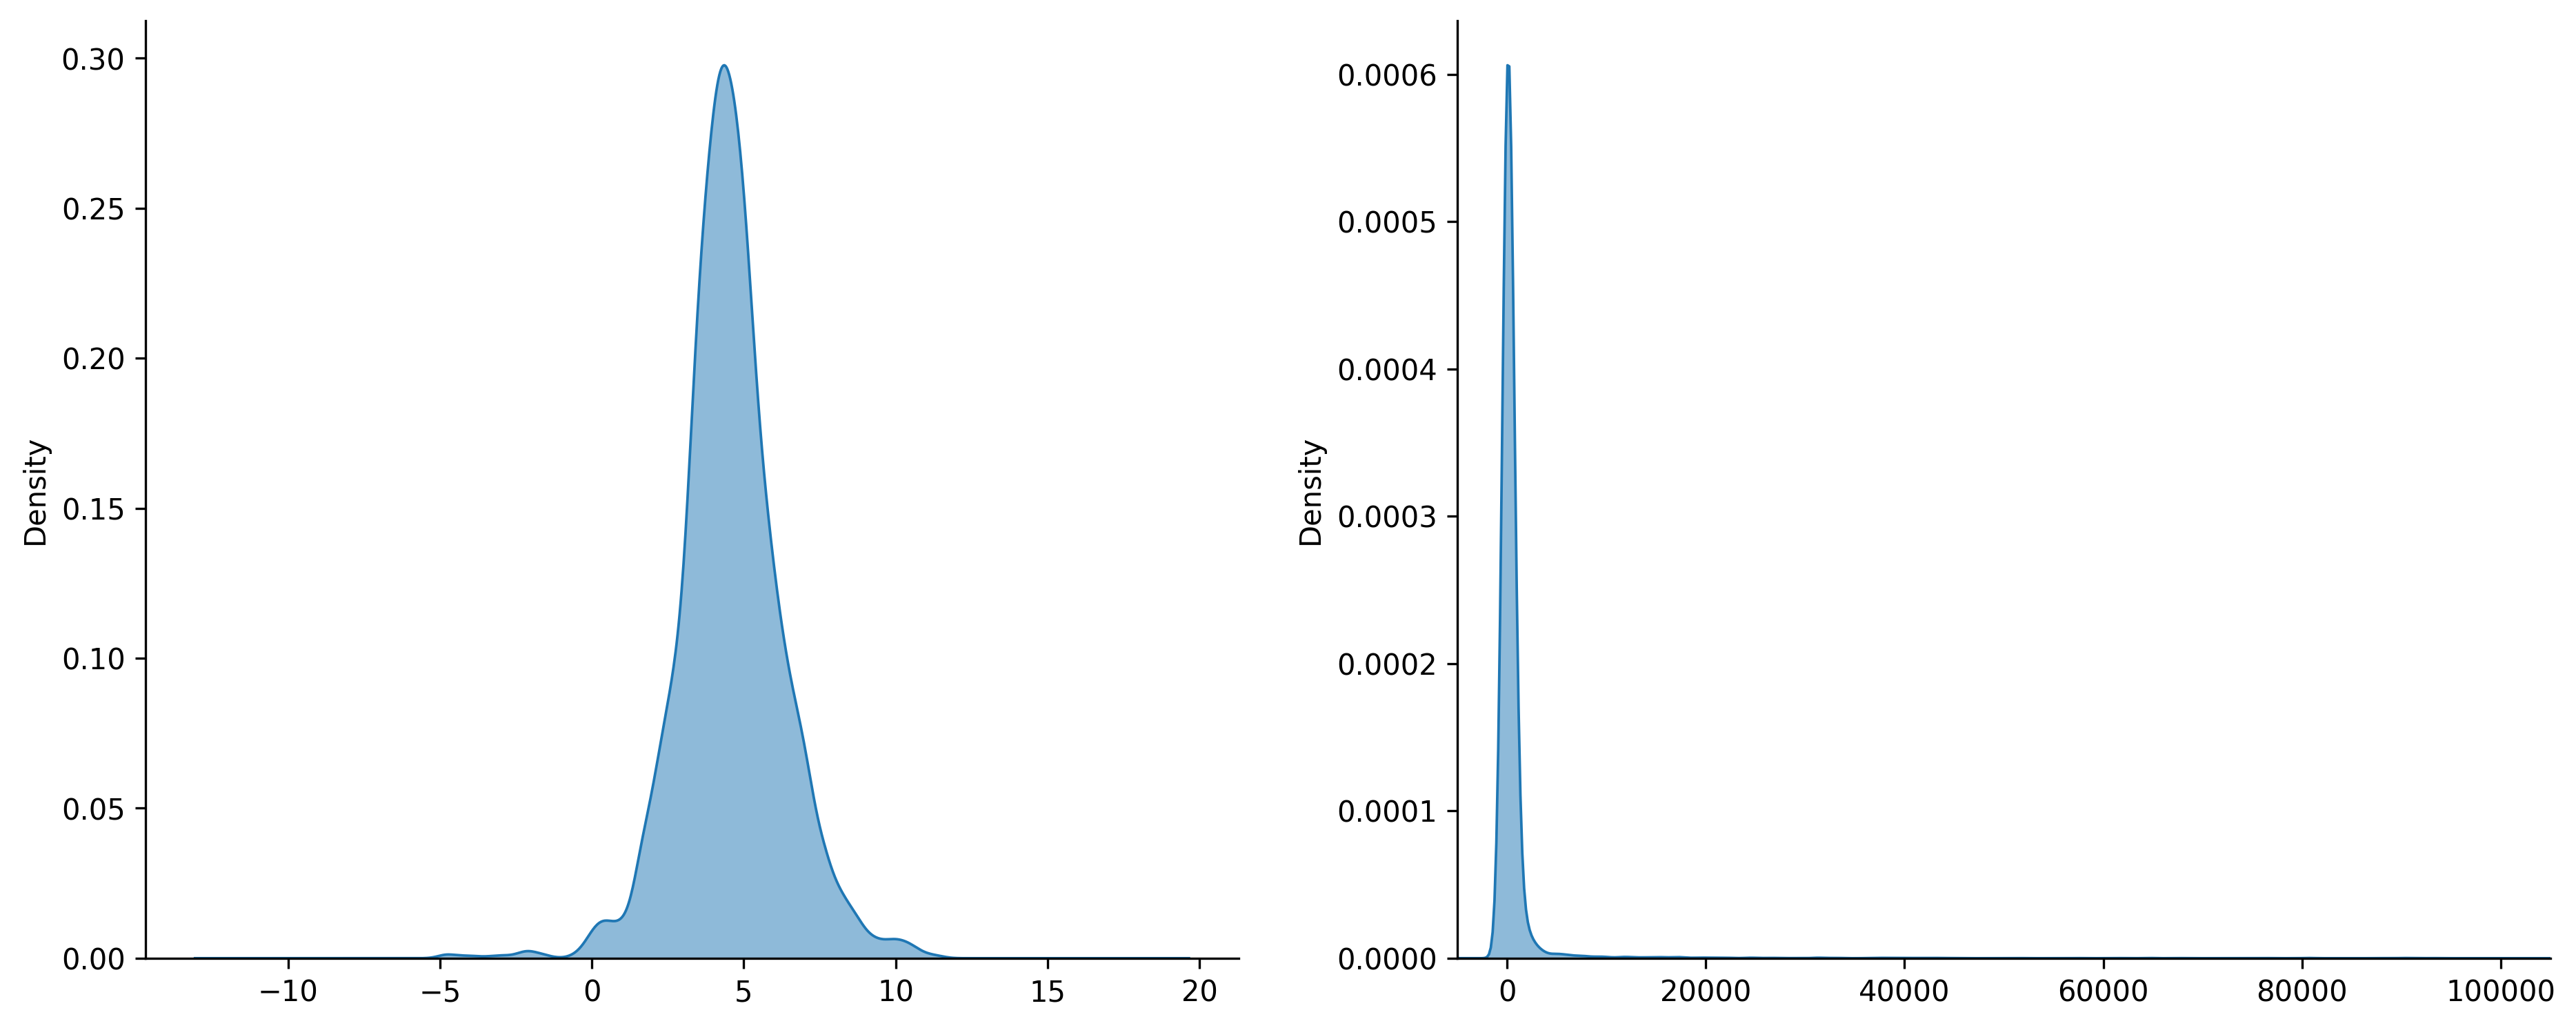

In [112]:
valid_range = (~df['price_usd'].isin([np.nan, np.inf, -np.inf]))\
            & (df['price_usd'] < 100000)\
            & (df['price_usd'] > 0.001)

# initiate subplots
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15, 6))

# plot log transformed price (left)
df['price_usd'][valid_range]\
    .sample(10000)\
    .transform(np.log)\
    .plot.kde(linewidth = .9, ax = ax1)

# fill density plot (left)
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax1.set_ylim(bottom = 0)

# plot not transformed price (right)
df['price_usd'][valid_range]\
    .sample(10000)\
    .plot.kde(linewidth = .9, ax = ax2)

# fill density plot (right)
line = ax2.lines[0].get_data()
ax2.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax2.set_ylim(bottom = 0)
ax2.set_xlim([-5000, 105000])

# asses attriation due to invalid values
k_org = len(df['price_usd'][~df['price_usd'].isin([np.nan, np.inf, -np.inf])])
k_val = len(df['price_usd'][valid_range])
print(k_org - k_val)

plt.show()

The prices of products on silkroad2 are extremely right skewed. Top tier prices range in USD +100,000. `log`-transformation helps to normalized selling prices considerably. Prices higher than USD 100,000 are considered outliers and are therefore excluded from the data. There by 24497 observations were coded as missing, which can be explained by: 
- missingness on the price variable
- `inf` value on the price value
- missingness on data value

In [45]:
# invalid cases are masked
df['price_usd'] = df['price_usd'].mask(~valid_range)

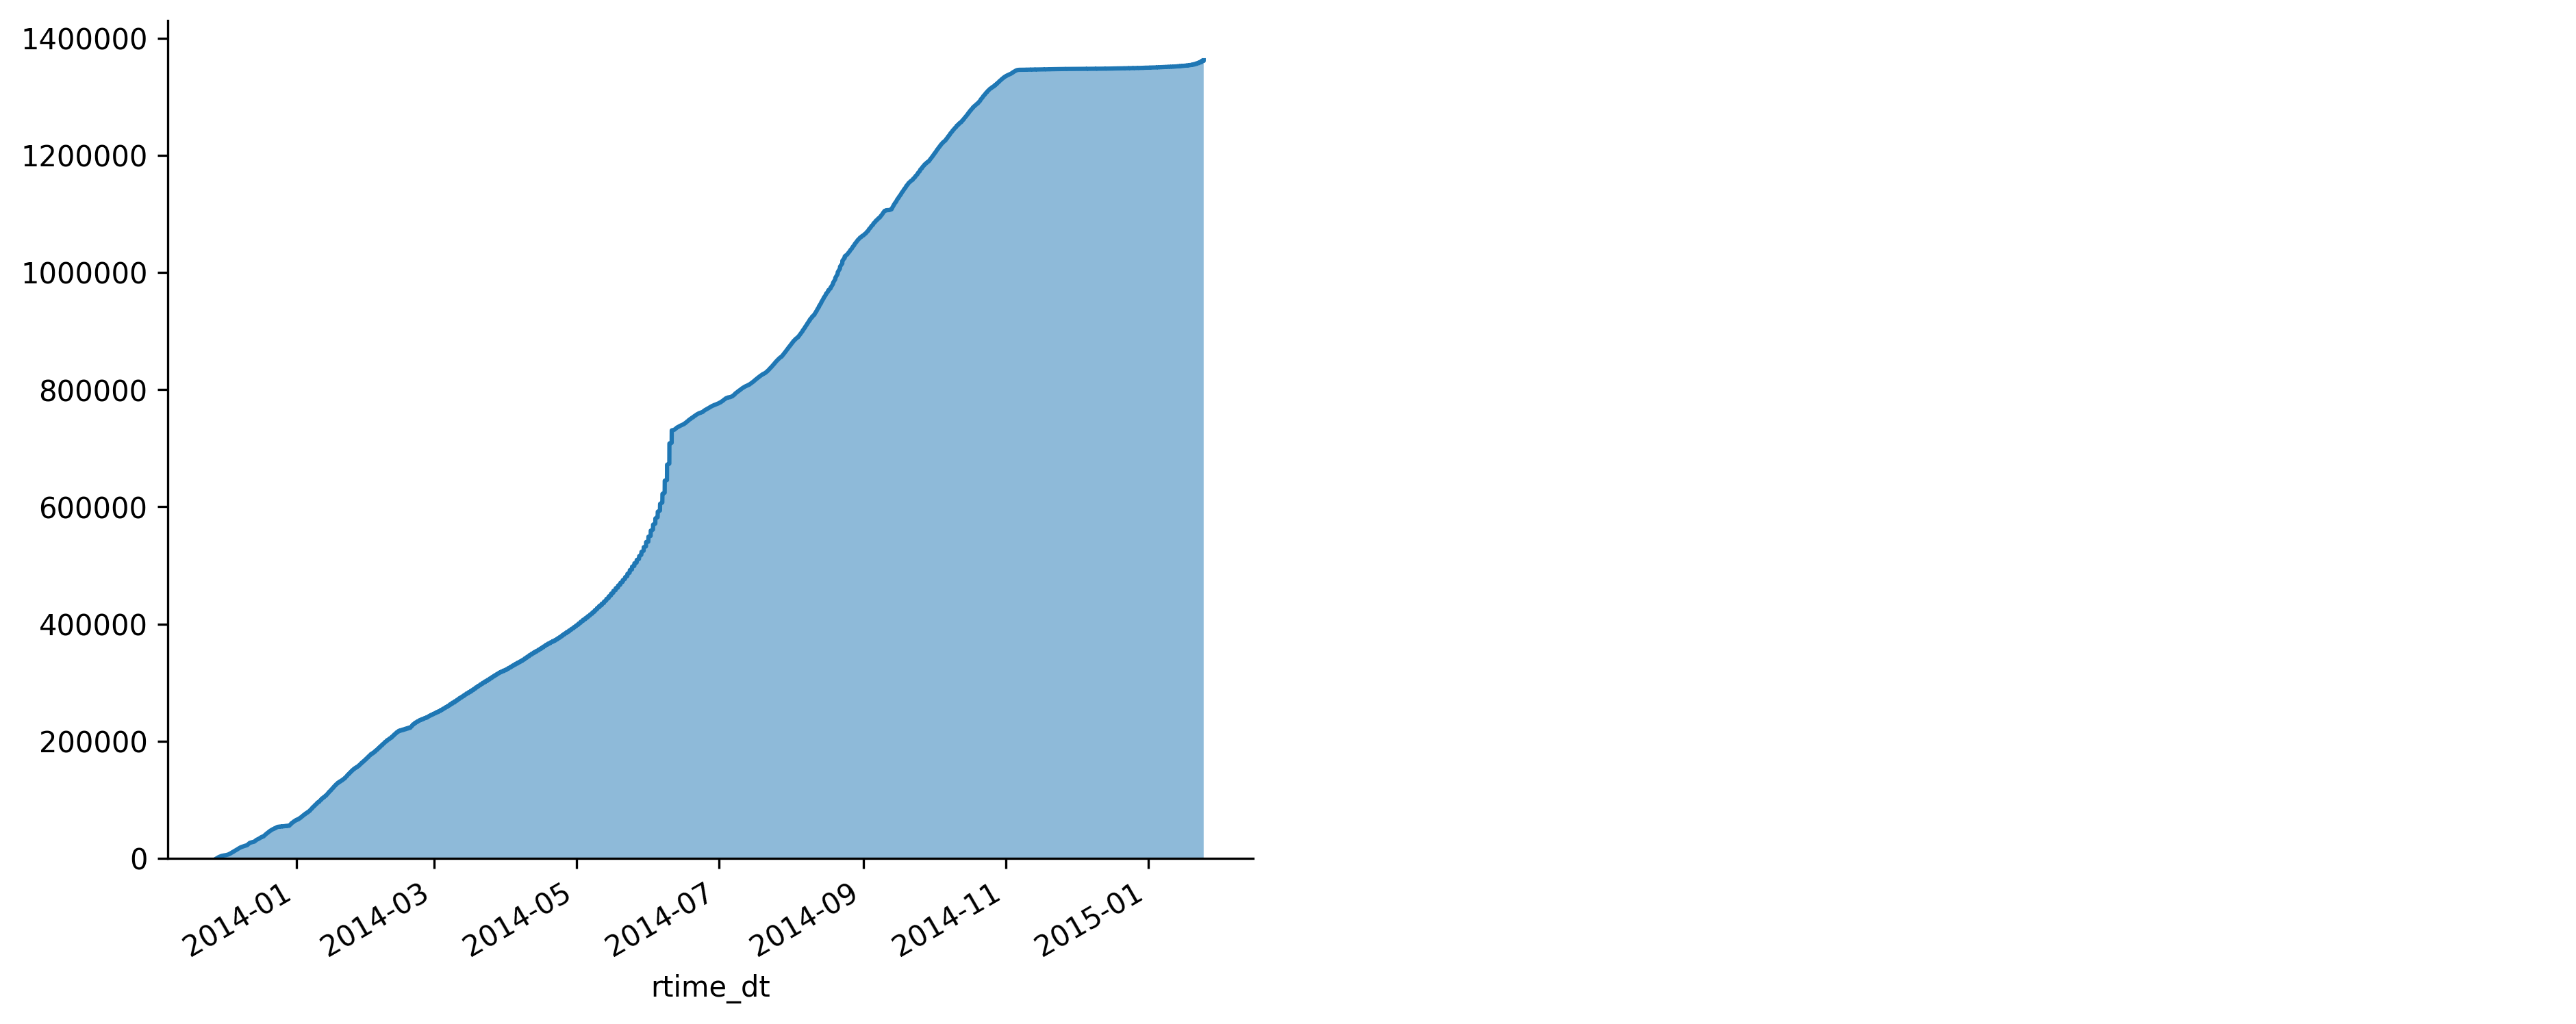

In [111]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15, 6))

#make cum_dist plot
df\
    .groupby('rtime_dt')['vendor']\
    .count()\
    .cumsum()\
    .plot(ax = ax1)
ax1.set_ylim(bottom = 0)

#fill cum_dist plot
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax1.set_ylim(bottom = 0)

#blank subplot
ax2.axis('off')

plt.show()